# GO GO GO

In [2]:
import pandas as pd
import numpy as np
from PIL import Image
import seaborn as sns
from transformers import pipeline
from matplotlib import colors, pyplot as plt
from tqdm.autonotebook import tqdm, trange
import gc
import os
import shutil
import random
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as tfs
from transformers import AutoModelForImageClassification, AutoImageProcessor, get_scheduler
from torch.optim import AdamW
from torch.optim import lr_scheduler
import torch.nn as nn
from sklearn.metrics import log_loss
import time

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

2024-04-14 19:14:01.094152: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-14 19:14:01.094271: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-14 19:14:01.216187: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Class imbalance fix

In [3]:
df = pd.read_csv('/kaggle/input/dataset/train.csv')
df.head()

,id,target
0,gL5fWrgNPU.jpg,0
1,KKWXJDN8uM.png,1
2,Wb2I0CXlAY.jpg,0
3,G7PLhKpaf7.jpeg,1
4,DEUkeefz6Z.jpg,0


In [8]:
train_df, val_df = train_test_split(df, test_size=0.2, shuffle=True, random_state=52, stratify=df['target'])

train_df.reset_index(drop= True , inplace= True )
val_df.reset_index(drop= True , inplace= True )

<Axes: xlabel='target', ylabel='Count'>

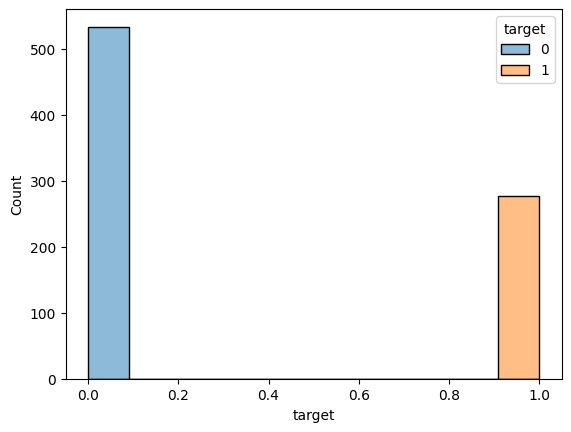

In [10]:
sns.histplot(data=train_df, x="target", hue='target')

In [12]:
os.makedirs('/kaggle/working/images')

folder_from = r'/kaggle/input/dataset/images'
folder_to = r'/kaggle/working/images'

for f in os.listdir(folder_from):
    if os.path.isfile(os.path.join(folder_from, f)):
        shutil.copy(os.path.join(folder_from, f), os.path.join(folder_to, f))
    if os.path.isdir(os.path.join(folder_from, f)):
        os.system(f'rd /S /Q {folder_to}\\{f}')
        shutil.copytree(os.path.join(folder_from, f), os.path.join(folder_to, f))

In [14]:
augmenters = {
    'Rotate': tfs.RandomRotation(10),
    'HFlip': tfs.RandomHorizontalFlip(p=1), 
    "gaussianblur": tfs.GaussianBlur(kernel_size=3)
}

aug_df = train_df.copy()

for path in train_df[train_df['target'] == 1]['id']:
    if len(path.split('.')) == 1:
        img = Image.open(f'/kaggle/input/dataset/images/{path}.png')
    else:
        img = Image.open(f'/kaggle/input/dataset/images/{path}')
        
    augmenter = random.choice(list(augmenters.values()))
    aug_img = augmenter(img)
    
    if len(path.split('.')) == 1:
        aug_img.save(f'/kaggle/working/images/aug_{path}.png')
    else:
        aug_img.save(f'/kaggle/working/images/aug_{path}')
    
    aug_df.loc[len(aug_df)] = ['aug_' + path, 1]

diff = (len(aug_df[aug_df['target'] == 1]) - len(aug_df[aug_df['target'] == 0]))

for i, path in enumerate(train_df[train_df['target'] == 0]['id']):
    if i == diff:
        break
        
    if len(path.split('.')) == 1:
        img = Image.open(f'/kaggle/input/dataset/images/{path}.png')
    else:
        img = Image.open(f'/kaggle/input/dataset/images/{path}')
        
    augmenter = random.choice(list(augmenters.values()))
    aug_img = augmenter(img)
    
    if len(path.split('.')) == 1:
        aug_img.save(f'/kaggle/working/images/aug_{path}.png')
    else:
        aug_img.save(f'/kaggle/working/images/aug_{path}')
        
    aug_df.loc[len(aug_df)] = ['aug_' + path, 0]

# Dataloaders

In [17]:
img_proc = AutoImageProcessor.from_pretrained('VaggP/convnext-tiny-finetuned-for-style-transfer-in-art-detection')

preprocessor_config.json:   0%|          | 0.00/352 [00:00<?, ?B/s]

In [59]:
modes = ['train', 'val', 'test']

class CustomDataset(Dataset):
    def __init__(self, df, mode):
        self.df = df
        self.mode = mode
        self.len_ = len(self.df)
        
        if self.mode not in modes:
            print(f'{self.mode} incorrect. Use actual in {modes}.')
            raise NameError
                
    def __len__(self):
        return self.len_
    
    def load_img(self, file):
        img = Image.open(file)
        img.load()
        return img
    
    def __getitem__(self, idx):
        if self.mode == 'test' or self.mode == 'val':
            transform = tfs.Compose([
                tfs.CenterCrop(size=(448,448))
            ])
        else:
             transform = tfs.Compose([
                 tfs.RandomRotation(10),
                 tfs.ColorJitter(brightness=0.2, contrast=0.2, hue=0.1),
                 tfs.RandomHorizontalFlip(p=0.25),
                 tfs.CenterCrop(size=(448,448)),
             ])
    
        if len(self.df.loc[idx, 'id'].split('.')) == 1:
            file = f'/kaggle/working/images/{self.df.loc[idx, "id"]}.png'
          
        else:
            file = f'/kaggle/working/images/{self.df.loc[idx, "id"]}'
        
        x = self.load_img(file)
        x = x.convert("RGB")
        x = transform(x)
        x = img_proc(x)['pixel_values'][0]
        x = torch.Tensor(x)
            
        if self.mode == 'test':
            return x
        else:
            y = self.df.loc[idx, 'target']
            return x,y

In [62]:
train_df = aug_df
val_df = val_df
test_df = pd.read_csv("/kaggle/input/dataset-kontur/test.csv")


train_dataset = CustomDataset(train_df, 'train')
val_dataset = CustomDataset(val_df, 'val')
test_dataset = CustomDataset(test_df, 'test')

dataset_sizes = {'train': len(train_dataset),
                 'val': len(val_dataset),
                 'test': len(test_dataset)}


train_dataloader = DataLoader(train_dataset, batch_size=32)
val_dataloader = DataLoader(val_dataset, batch_size=32)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=32)


dataloaders = {"train": train_dataloader,
              "val": val_dataloader,
              "test": test_dataloader}

# Train loop

In [26]:
def train_model(model, 
                criterion,
                optimizer,
                scheduler,
                num_epochs=25,
                early_stopping=7,
                use_gpu=True):
    
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0
    best_loss = 1000
    counter=0
    models_wts = []
    
    losses = {'train': [], "val": []}
    accs = {'train': [], "val": []}

    pbar = trange(num_epochs, desc="Epoch:")

    for epoch in pbar:
        lr = optimizer.param_groups[0]['lr']
        
        # каждя эпоха имеет обучающую и тестовую стадии
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train(True)  # установаить модель в режим обучения
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # итерируемся по батчам
            for i, data in enumerate(tqdm(dataloaders[phase],
                                          leave=False,
                                          desc=f"{phase} iter:")):
                # получаем картинки и метки
                inputs, labels = data
                
                # оборачиваем в переменные
                if use_gpu:
                    inputs = inputs.cuda()
                    labels = labels.cuda()
                else:
                    inputs, labels = inputs, labels

                # инициализируем градиенты параметров
                if phase=="train":
                    optimizer.zero_grad()

                # forward pass
                if phase == "eval":
                    with torch.no_grad():
                        logits = model(inputs).logits
                else:
                    logits = model(inputs).logits
                
                # Меняем местами столбцы, чтобы порядок вероятностей соответсвовал задаче
                logits = torch.index_select(logits, 1, torch.LongTensor([1, 0]).cuda())
                
                preds = torch.argmax(logits, -1)
                loss = criterion(logits, labels)
                
                # backward pass + оптимизируем только если это стадия обучения
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # статистика
                running_loss += loss.item()
                running_corrects += int(torch.sum(preds == labels.data))
                
                # очищаем пямять
                del inputs
                del labels
                gc.collect()
                torch.cuda.empty_cache()

            epoch_loss = running_loss / (i+1)
            epoch_acc = running_corrects / dataset_sizes[phase]
            
            if phase == 'val':
                scheduler.step(epoch_loss)
                
            
            losses[phase].append(epoch_loss)
            
            pbar.set_description('{} Loss: {:.4f} Acc: {:.4f}'.format(
                                    phase, epoch_loss, epoch_acc
                                ))
            print('{} epoch {} phase: Loss: {:.4f} Acc: {:.4f} with lr= {}'.format(
                                    epoch, phase, epoch_loss, epoch_acc, lr))
            if phase == "val":
                counter += 1
            
            # если достиглось лучшее качество, то запомним веса модели
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = model.state_dict()
                counter = 0
                
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                
            accs[phase].append(epoch_acc)
            
            if phase == 'val':
                models_wts.append(model.state_dict())
                
            if counter >= early_stopping:
                print(f"\nTraining was stopped because val loss wasn't minimized for {early_stopping} epochs")
                time_elapsed = time.time() - since
                print('Training complete in {:.0f}m {:.0f}s'.format(
                    time_elapsed // 60, time_elapsed % 60))
                print('Best val Acc: {:4f}'.format(best_acc))

                # загрузим лучшие веса модели
                model.load_state_dict(best_model_wts)
                return model, losses, accs, models_wts
                
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # загрузим лучшие веса модели
    model.load_state_dict(best_model_wts)
    return model, losses, accs, models_wts

In [24]:
def plot_trainig(train_losses, valid_losses, valid_accuracies=None):
    plt.figure(figsize=(12, 9))
    plt.subplot(2, 1, 1)
    plt.xlabel("epoch")
    plt.plot(train_losses, label="train_loss", color='black')
    plt.plot(valid_losses, label="valid_loss", color='blue')
    plt.legend()
    
    if valid_accuracies != None:
        plt.subplot(2, 1, 2)
        plt.xlabel("epoch")
        plt.plot(valid_accuracies, label="valid accuracy")
    plt.legend()

In [25]:
def evaluate(model, use_gpu=True):
    model.eval()
    
    runninig_correct = 0
    val_loss = 0
    for num_batch, data in enumerate(dataloaders['val']):

        # получаем картинки и метки
        inputs, labels = data
        
        # переносим на gpu, если возможно
        if use_gpu:
            inputs = inputs.cuda()
            labels = labels.cpu()
            
        # forard pass
        logits = model(inputs).logits.cpu()
        
        # Меняем местами столбцы, чтобы порядок вероятностей соответсвовал задаче
        logits = torch.index_select(logits, 1, torch.LongTensor([1, 0]))
        
        probs = torch.softmax(logits, dim=1).detach().numpy()
        
        _, predicted = torch.max(logits, 1)
        
        runninig_correct += int(torch.sum(predicted == labels))
        val_loss += log_loss(labels.cpu(), probs)
        
    return val_loss / (num_batch+1), runninig_correct / dataset_sizes['val']

In [63]:
model = AutoModelForImageClassification.from_pretrained(
	'VaggP/convnext-tiny-finetuned-for-style-transfer-in-art-detection',
	num_labels=2)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.00501)
criterion = nn.CrossEntropyLoss()
num_epochs = 50
num_training_steps = num_epochs * len(train_dataloader)

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                           mode='min',
                                                           factor=0.3,
                                                            patience=3)

device = 'cuda'
model.to(device)
None

In [65]:
for i, param in enumerate(model.parameters()):
    if i not in [180, 181]:
        param.requires_grad = False

In [67]:
best_model, losses, accs, models_wts = train_model(model = model,
                                                   criterion = criterion,
                                                   optimizer = optimizer,
                                                   scheduler = lr_scheduler,
                                                   num_epochs = num_epochs,
                                                  early_stopping = 15)

Epoch::   0%|          | 0/50 [00:00<?, ?it/s]

train iter::   0%|          | 0/26 [00:00<?, ?it/s]

0 epoch train phase: Loss: 0.3832 Acc: 0.8578 with lr= 0.005


val iter::   0%|          | 0/7 [00:00<?, ?it/s]

0 epoch val phase: Loss: 0.1677 Acc: 0.9655 with lr= 0.005


train iter::   0%|          | 0/26 [00:00<?, ?it/s]

1 epoch train phase: Loss: 0.1391 Acc: 0.9580 with lr= 0.005


val iter::   0%|          | 0/7 [00:00<?, ?it/s]

1 epoch val phase: Loss: 0.1171 Acc: 0.9655 with lr= 0.005


train iter::   0%|          | 0/26 [00:00<?, ?it/s]

2 epoch train phase: Loss: 0.0923 Acc: 0.9790 with lr= 0.005


val iter::   0%|          | 0/7 [00:00<?, ?it/s]

2 epoch val phase: Loss: 0.1003 Acc: 0.9606 with lr= 0.005


train iter::   0%|          | 0/26 [00:00<?, ?it/s]

3 epoch train phase: Loss: 0.0714 Acc: 0.9839 with lr= 0.005


val iter::   0%|          | 0/7 [00:00<?, ?it/s]

3 epoch val phase: Loss: 0.0908 Acc: 0.9655 with lr= 0.005


train iter::   0%|          | 0/26 [00:00<?, ?it/s]

4 epoch train phase: Loss: 0.0586 Acc: 0.9889 with lr= 0.005


val iter::   0%|          | 0/7 [00:00<?, ?it/s]

4 epoch val phase: Loss: 0.0870 Acc: 0.9655 with lr= 0.005


train iter::   0%|          | 0/26 [00:00<?, ?it/s]

5 epoch train phase: Loss: 0.0470 Acc: 0.9963 with lr= 0.005


val iter::   0%|          | 0/7 [00:00<?, ?it/s]

5 epoch val phase: Loss: 0.0820 Acc: 0.9704 with lr= 0.005


train iter::   0%|          | 0/26 [00:00<?, ?it/s]

6 epoch train phase: Loss: 0.0408 Acc: 0.9951 with lr= 0.005


val iter::   0%|          | 0/7 [00:00<?, ?it/s]

6 epoch val phase: Loss: 0.0774 Acc: 0.9754 with lr= 0.005


train iter::   0%|          | 0/26 [00:00<?, ?it/s]

7 epoch train phase: Loss: 0.0350 Acc: 0.9975 with lr= 0.005


val iter::   0%|          | 0/7 [00:00<?, ?it/s]

7 epoch val phase: Loss: 0.0748 Acc: 0.9754 with lr= 0.005


train iter::   0%|          | 0/26 [00:00<?, ?it/s]

8 epoch train phase: Loss: 0.0283 Acc: 0.9975 with lr= 0.005


val iter::   0%|          | 0/7 [00:00<?, ?it/s]

8 epoch val phase: Loss: 0.0737 Acc: 0.9655 with lr= 0.005


train iter::   0%|          | 0/26 [00:00<?, ?it/s]

9 epoch train phase: Loss: 0.0248 Acc: 0.9988 with lr= 0.005


val iter::   0%|          | 0/7 [00:00<?, ?it/s]

9 epoch val phase: Loss: 0.0732 Acc: 0.9754 with lr= 0.005


train iter::   0%|          | 0/26 [00:00<?, ?it/s]

10 epoch train phase: Loss: 0.0230 Acc: 0.9988 with lr= 0.005


val iter::   0%|          | 0/7 [00:00<?, ?it/s]

10 epoch val phase: Loss: 0.0747 Acc: 0.9655 with lr= 0.005


train iter::   0%|          | 0/26 [00:00<?, ?it/s]

11 epoch train phase: Loss: 0.0198 Acc: 0.9988 with lr= 0.005


val iter::   0%|          | 0/7 [00:00<?, ?it/s]

11 epoch val phase: Loss: 0.0735 Acc: 0.9704 with lr= 0.005


train iter::   0%|          | 0/26 [00:00<?, ?it/s]

12 epoch train phase: Loss: 0.0177 Acc: 0.9988 with lr= 0.005


val iter::   0%|          | 0/7 [00:00<?, ?it/s]

12 epoch val phase: Loss: 0.0745 Acc: 0.9655 with lr= 0.005


train iter::   0%|          | 0/26 [00:00<?, ?it/s]

13 epoch train phase: Loss: 0.0163 Acc: 0.9988 with lr= 0.005


val iter::   0%|          | 0/7 [00:00<?, ?it/s]

13 epoch val phase: Loss: 0.0751 Acc: 0.9655 with lr= 0.005


train iter::   0%|          | 0/26 [00:00<?, ?it/s]

14 epoch train phase: Loss: 0.0148 Acc: 0.9988 with lr= 0.0015


val iter::   0%|          | 0/7 [00:00<?, ?it/s]

14 epoch val phase: Loss: 0.0738 Acc: 0.9704 with lr= 0.0015


train iter::   0%|          | 0/26 [00:00<?, ?it/s]

15 epoch train phase: Loss: 0.0146 Acc: 1.0000 with lr= 0.0015


val iter::   0%|          | 0/7 [00:00<?, ?it/s]

15 epoch val phase: Loss: 0.0738 Acc: 0.9704 with lr= 0.0015


train iter::   0%|          | 0/26 [00:00<?, ?it/s]

16 epoch train phase: Loss: 0.0141 Acc: 1.0000 with lr= 0.0015


val iter::   0%|          | 0/7 [00:00<?, ?it/s]

16 epoch val phase: Loss: 0.0726 Acc: 0.9704 with lr= 0.0015


train iter::   0%|          | 0/26 [00:00<?, ?it/s]

17 epoch train phase: Loss: 0.0140 Acc: 1.0000 with lr= 0.0015


val iter::   0%|          | 0/7 [00:00<?, ?it/s]

17 epoch val phase: Loss: 0.0716 Acc: 0.9704 with lr= 0.0015


train iter::   0%|          | 0/26 [00:00<?, ?it/s]

18 epoch train phase: Loss: 0.0130 Acc: 1.0000 with lr= 0.0015


val iter::   0%|          | 0/7 [00:00<?, ?it/s]

18 epoch val phase: Loss: 0.0706 Acc: 0.9704 with lr= 0.0015


train iter::   0%|          | 0/26 [00:00<?, ?it/s]

19 epoch train phase: Loss: 0.0127 Acc: 1.0000 with lr= 0.0015


val iter::   0%|          | 0/7 [00:00<?, ?it/s]

19 epoch val phase: Loss: 0.0710 Acc: 0.9704 with lr= 0.0015


train iter::   0%|          | 0/26 [00:00<?, ?it/s]

20 epoch train phase: Loss: 0.0124 Acc: 1.0000 with lr= 0.0015


val iter::   0%|          | 0/7 [00:00<?, ?it/s]

20 epoch val phase: Loss: 0.0710 Acc: 0.9704 with lr= 0.0015


train iter::   0%|          | 0/26 [00:00<?, ?it/s]

21 epoch train phase: Loss: 0.0123 Acc: 1.0000 with lr= 0.0015


val iter::   0%|          | 0/7 [00:00<?, ?it/s]

21 epoch val phase: Loss: 0.0709 Acc: 0.9704 with lr= 0.0015


train iter::   0%|          | 0/26 [00:00<?, ?it/s]

22 epoch train phase: Loss: 0.0120 Acc: 1.0000 with lr= 0.0015


val iter::   0%|          | 0/7 [00:00<?, ?it/s]

22 epoch val phase: Loss: 0.0700 Acc: 0.9704 with lr= 0.0015


train iter::   0%|          | 0/26 [00:00<?, ?it/s]

23 epoch train phase: Loss: 0.0118 Acc: 1.0000 with lr= 0.0015


val iter::   0%|          | 0/7 [00:00<?, ?it/s]

23 epoch val phase: Loss: 0.0695 Acc: 0.9704 with lr= 0.0015


train iter::   0%|          | 0/26 [00:00<?, ?it/s]

24 epoch train phase: Loss: 0.0118 Acc: 1.0000 with lr= 0.0015


val iter::   0%|          | 0/7 [00:00<?, ?it/s]

24 epoch val phase: Loss: 0.0708 Acc: 0.9704 with lr= 0.0015


train iter::   0%|          | 0/26 [00:00<?, ?it/s]

25 epoch train phase: Loss: 0.0109 Acc: 1.0000 with lr= 0.0015


val iter::   0%|          | 0/7 [00:00<?, ?it/s]

25 epoch val phase: Loss: 0.0690 Acc: 0.9704 with lr= 0.0015


train iter::   0%|          | 0/26 [00:00<?, ?it/s]

26 epoch train phase: Loss: 0.0112 Acc: 1.0000 with lr= 0.0015


val iter::   0%|          | 0/7 [00:00<?, ?it/s]

26 epoch val phase: Loss: 0.0705 Acc: 0.9704 with lr= 0.0015


train iter::   0%|          | 0/26 [00:00<?, ?it/s]

27 epoch train phase: Loss: 0.0104 Acc: 1.0000 with lr= 0.0015


val iter::   0%|          | 0/7 [00:00<?, ?it/s]

27 epoch val phase: Loss: 0.0694 Acc: 0.9704 with lr= 0.0015


train iter::   0%|          | 0/26 [00:00<?, ?it/s]

28 epoch train phase: Loss: 0.0106 Acc: 1.0000 with lr= 0.0015


val iter::   0%|          | 0/7 [00:00<?, ?it/s]

28 epoch val phase: Loss: 0.0688 Acc: 0.9704 with lr= 0.0015


train iter::   0%|          | 0/26 [00:00<?, ?it/s]

29 epoch train phase: Loss: 0.0091 Acc: 1.0000 with lr= 0.0015


val iter::   0%|          | 0/7 [00:00<?, ?it/s]

29 epoch val phase: Loss: 0.0688 Acc: 0.9704 with lr= 0.0015


train iter::   0%|          | 0/26 [00:00<?, ?it/s]

30 epoch train phase: Loss: 0.0098 Acc: 1.0000 with lr= 0.0015


val iter::   0%|          | 0/7 [00:00<?, ?it/s]

30 epoch val phase: Loss: 0.0689 Acc: 0.9704 with lr= 0.0015


train iter::   0%|          | 0/26 [00:00<?, ?it/s]

31 epoch train phase: Loss: 0.0096 Acc: 1.0000 with lr= 0.0015


val iter::   0%|          | 0/7 [00:00<?, ?it/s]

31 epoch val phase: Loss: 0.0695 Acc: 0.9704 with lr= 0.0015


train iter::   0%|          | 0/26 [00:00<?, ?it/s]

32 epoch train phase: Loss: 0.0093 Acc: 1.0000 with lr= 0.0015


val iter::   0%|          | 0/7 [00:00<?, ?it/s]

32 epoch val phase: Loss: 0.0689 Acc: 0.9704 with lr= 0.0015


train iter::   0%|          | 0/26 [00:00<?, ?it/s]

33 epoch train phase: Loss: 0.0089 Acc: 1.0000 with lr= 0.00045


val iter::   0%|          | 0/7 [00:00<?, ?it/s]

33 epoch val phase: Loss: 0.0691 Acc: 0.9704 with lr= 0.00045


train iter::   0%|          | 0/26 [00:00<?, ?it/s]

34 epoch train phase: Loss: 0.0088 Acc: 1.0000 with lr= 0.00045


val iter::   0%|          | 0/7 [00:00<?, ?it/s]

34 epoch val phase: Loss: 0.0690 Acc: 0.9704 with lr= 0.00045


train iter::   0%|          | 0/26 [00:00<?, ?it/s]

35 epoch train phase: Loss: 0.0088 Acc: 1.0000 with lr= 0.00045


val iter::   0%|          | 0/7 [00:00<?, ?it/s]

35 epoch val phase: Loss: 0.0686 Acc: 0.9704 with lr= 0.00045


train iter::   0%|          | 0/26 [00:00<?, ?it/s]

36 epoch train phase: Loss: 0.0085 Acc: 1.0000 with lr= 0.00045


val iter::   0%|          | 0/7 [00:00<?, ?it/s]

36 epoch val phase: Loss: 0.0687 Acc: 0.9704 with lr= 0.00045


train iter::   0%|          | 0/26 [00:00<?, ?it/s]

37 epoch train phase: Loss: 0.0088 Acc: 1.0000 with lr= 0.00045


val iter::   0%|          | 0/7 [00:00<?, ?it/s]

37 epoch val phase: Loss: 0.0690 Acc: 0.9704 with lr= 0.00045


train iter::   0%|          | 0/26 [00:00<?, ?it/s]

38 epoch train phase: Loss: 0.0086 Acc: 1.0000 with lr= 0.00045


val iter::   0%|          | 0/7 [00:00<?, ?it/s]

38 epoch val phase: Loss: 0.0689 Acc: 0.9704 with lr= 0.00045


train iter::   0%|          | 0/26 [00:00<?, ?it/s]

39 epoch train phase: Loss: 0.0086 Acc: 1.0000 with lr= 0.00045


val iter::   0%|          | 0/7 [00:00<?, ?it/s]

39 epoch val phase: Loss: 0.0688 Acc: 0.9704 with lr= 0.00045


train iter::   0%|          | 0/26 [00:00<?, ?it/s]

40 epoch train phase: Loss: 0.0087 Acc: 1.0000 with lr= 0.000135


val iter::   0%|          | 0/7 [00:00<?, ?it/s]

40 epoch val phase: Loss: 0.0687 Acc: 0.9704 with lr= 0.000135


train iter::   0%|          | 0/26 [00:00<?, ?it/s]

41 epoch train phase: Loss: 0.0084 Acc: 1.0000 with lr= 0.000135


val iter::   0%|          | 0/7 [00:00<?, ?it/s]

41 epoch val phase: Loss: 0.0689 Acc: 0.9704 with lr= 0.000135


train iter::   0%|          | 0/26 [00:00<?, ?it/s]

42 epoch train phase: Loss: 0.0084 Acc: 1.0000 with lr= 0.000135


val iter::   0%|          | 0/7 [00:00<?, ?it/s]

42 epoch val phase: Loss: 0.0690 Acc: 0.9704 with lr= 0.000135


train iter::   0%|          | 0/26 [00:00<?, ?it/s]

43 epoch train phase: Loss: 0.0088 Acc: 1.0000 with lr= 0.000135


val iter::   0%|          | 0/7 [00:00<?, ?it/s]

43 epoch val phase: Loss: 0.0691 Acc: 0.9704 with lr= 0.000135


train iter::   0%|          | 0/26 [00:00<?, ?it/s]

44 epoch train phase: Loss: 0.0086 Acc: 1.0000 with lr= 4.05e-05


val iter::   0%|          | 0/7 [00:00<?, ?it/s]

44 epoch val phase: Loss: 0.0691 Acc: 0.9704 with lr= 4.05e-05


train iter::   0%|          | 0/26 [00:00<?, ?it/s]

45 epoch train phase: Loss: 0.0082 Acc: 1.0000 with lr= 4.05e-05


val iter::   0%|          | 0/7 [00:00<?, ?it/s]

45 epoch val phase: Loss: 0.0691 Acc: 0.9704 with lr= 4.05e-05


train iter::   0%|          | 0/26 [00:00<?, ?it/s]

46 epoch train phase: Loss: 0.0086 Acc: 1.0000 with lr= 4.05e-05


val iter::   0%|          | 0/7 [00:00<?, ?it/s]

46 epoch val phase: Loss: 0.0691 Acc: 0.9704 with lr= 4.05e-05


train iter::   0%|          | 0/26 [00:00<?, ?it/s]

47 epoch train phase: Loss: 0.0087 Acc: 1.0000 with lr= 4.05e-05


val iter::   0%|          | 0/7 [00:00<?, ?it/s]

47 epoch val phase: Loss: 0.0690 Acc: 0.9704 with lr= 4.05e-05


train iter::   0%|          | 0/26 [00:00<?, ?it/s]

48 epoch train phase: Loss: 0.0086 Acc: 1.0000 with lr= 1.215e-05


val iter::   0%|          | 0/7 [00:00<?, ?it/s]

48 epoch val phase: Loss: 0.0690 Acc: 0.9704 with lr= 1.215e-05


train iter::   0%|          | 0/26 [00:00<?, ?it/s]

49 epoch train phase: Loss: 0.0081 Acc: 1.0000 with lr= 1.215e-05


val iter::   0%|          | 0/7 [00:00<?, ?it/s]

49 epoch val phase: Loss: 0.0690 Acc: 0.9704 with lr= 1.215e-05
Training complete in 26m 13s
Best val Acc: 0.975369


In [69]:
val_loss, acc = evaluate(best_model)
print('val_loss: ', val_loss)
print('val_accuracy: ', acc)

val_loss:  0.06902687070039205
val_accuracy:  0.9704433497536946


In [68]:
np.argmin(losses['val']), min(losses['val'])

(35, 0.06863667762705258)

In [70]:
np.argmax(accs['val']), max(accs['val'])

(6, 0.9753694581280788)

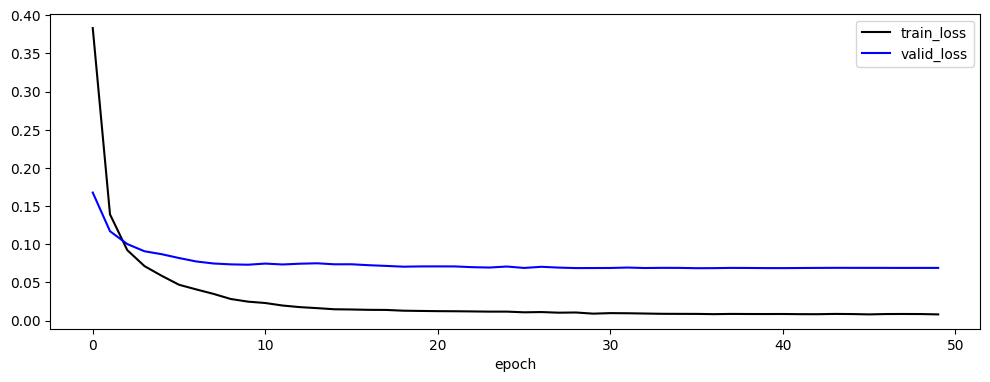

In [71]:
plot_trainig(losses['train'], losses['val'])

# Predict

In [38]:
def predict(model, test_dataloader):
    result = None 
    with torch.no_grad():
        for inputs in tqdm(test_dataloader):
            inputs = inputs.cuda()
            model.eval()
            logits = model(inputs).logits
            if result == None:
                result = logits
            else:
                result = torch.cat([result, logits], 0)
        
        probs = torch.softmax(result, dim=1)
    return result, probs

In [72]:
logits, probs = predict(best_model, test_dataloader)

  0%|          | 0/16 [00:00<?, ?it/s]

In [55]:
submission_df = pd.read_csv('/kaggle/input/dataset/test.csv')
submission_df.head()

,id
0,Qt1fGUB0Vz.jpeg
1,j4Rhioq7R3.jpeg
2,rD0hgFHJUZ.jpeg
3,aY5z1EJsJ6.jpeg
4,qZ3IoxD2TE.jpeg


In [73]:
submission_df['target'] = probs[:, 0].cpu()
submission_df.head(10)

,id,target
0,Qt1fGUB0Vz.jpeg,0.001697
1,j4Rhioq7R3.jpeg,0.101787
2,rD0hgFHJUZ.jpeg,0.000078
3,aY5z1EJsJ6.jpeg,0.999768
4,qZ3IoxD2TE.jpeg,0.000494
5,BOFtxEERkV.jpeg,0.012126
6,9hqOXpYGbK.jpeg,0.931967
7,BhA8T8Ij32.jpeg,0.001540
8,rXexUH9dCM.jpeg,0.001438
9,RdYDVBxwvq.jpeg,0.999032


In [77]:
submission_df.to_csv('submission_convnext_2.csv', index=None)

# Save model

In [71]:
weights = best_model.state_dict()

In [72]:
torch.save(weights, 'convnext_model.pth')